In [1]:
# Sagar Sahu
# IBM Quantum Challenge 2024- Lab 4

%pip install qiskit[visualization]==1.0.2
%pip install qiskit-ibm-runtime
%pip install qiskit-aer
%pip install graphviz
%pip install qiskit-serverless -U
%pip install qiskit-transpiler-service -U

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import RealAmplitudes
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler import InstructionProperties
from qiskit.visualization import plot_distribution
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.primitives import StatevectorEstimator

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import (
    QiskitRuntimeService, 
    EstimatorV2 as Estimator,
    SamplerV2 as Sampler,
    EstimatorOptions
)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 4.8 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=faca6c7912ae983a8d39cdf1aeaab4103e26ea89442971ad2bdfd6f52b3b9925
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 5.4 MB/s eta 0:00:00
  Installing build dependencies ... - \

In [2]:
# Define num_qubits, the number of qubits, for the rest of the Lab
num_qubits = 5

# Load the dictionary 
birds_dataset = pd.read_csv('/kaggle/input/birds-dataset/birds_dataset.csv') 

# Check if the dataset is loaded correctly - coefficients should be complex numbers
for i in range(2**num_qubits):
    key = 'c%.0f' %i
    birds_dataset[key] = birds_dataset[key].astype(np.complex128)

# Print the dataset
birds_dataset

,names,c0,c1,c2,c3,c4,c5,c6,c7,c8,...,c22,c23,c24,c25,c26,c27,c28,c29,c30,c31
0,Falcon,0.707107+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.707107+0.000000j
1,Hummingbird,0.000000+0.000000j,0.707107+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.707107+0.000000j,0.000000+0.000000j
2,Eagle,0.000000+0.000000j,0.000000+0.000000j,0.707107+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.000000+0.000000j,0.000000+0.000000j,0.707107+0.000000j,0.000000+0.000000j,0.000000+0.000000j
3,Osprey,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.707107+0.000000j,0.000000+0.000000j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.000000+0.000000j,0.707107+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
4,Heron,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.707107+0.000000j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.707107+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
5,Peacock,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
6,Parrot,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.0+0.0j,1.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
7,Swan,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.0+0.0j,0.0+0.0j,1.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
8,Toucan,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.0+0.0j,0.0+0.0j,0.0+0.0j,1.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
9,Cardinal,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j


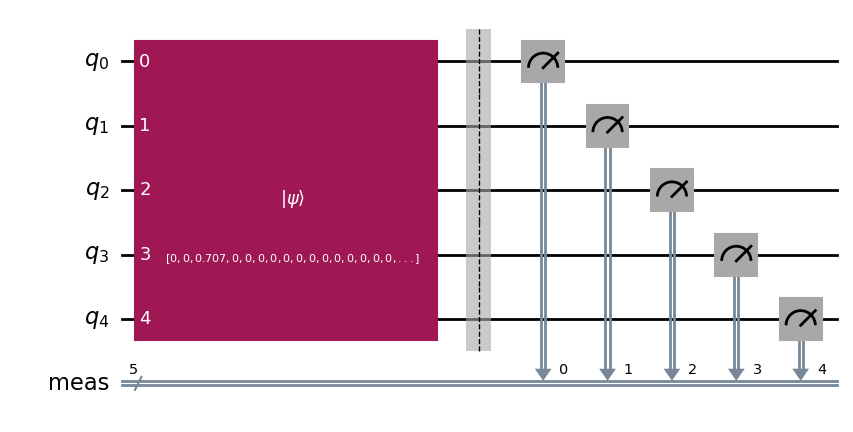

In [3]:
list_coefficients = []
list_labels = [1,1,1,1,1,0,0,0,0,0]
for index, row in birds_dataset.iterrows():
    coefficients = [row['c%.0f' % i] for i in range(2**num_qubits)]
    list_coefficients.append(coefficients)

index_bird = 2 # You can check different birds by changing the index
amplitudes = list_coefficients[index_bird]

# Build the amplitude embedding 
qc = QuantumCircuit(5)
qc.initialize(amplitudes, range(num_qubits))
qc.measure_all()

# Draw the amplitude embedding circuit
qc.draw(output="mpl")

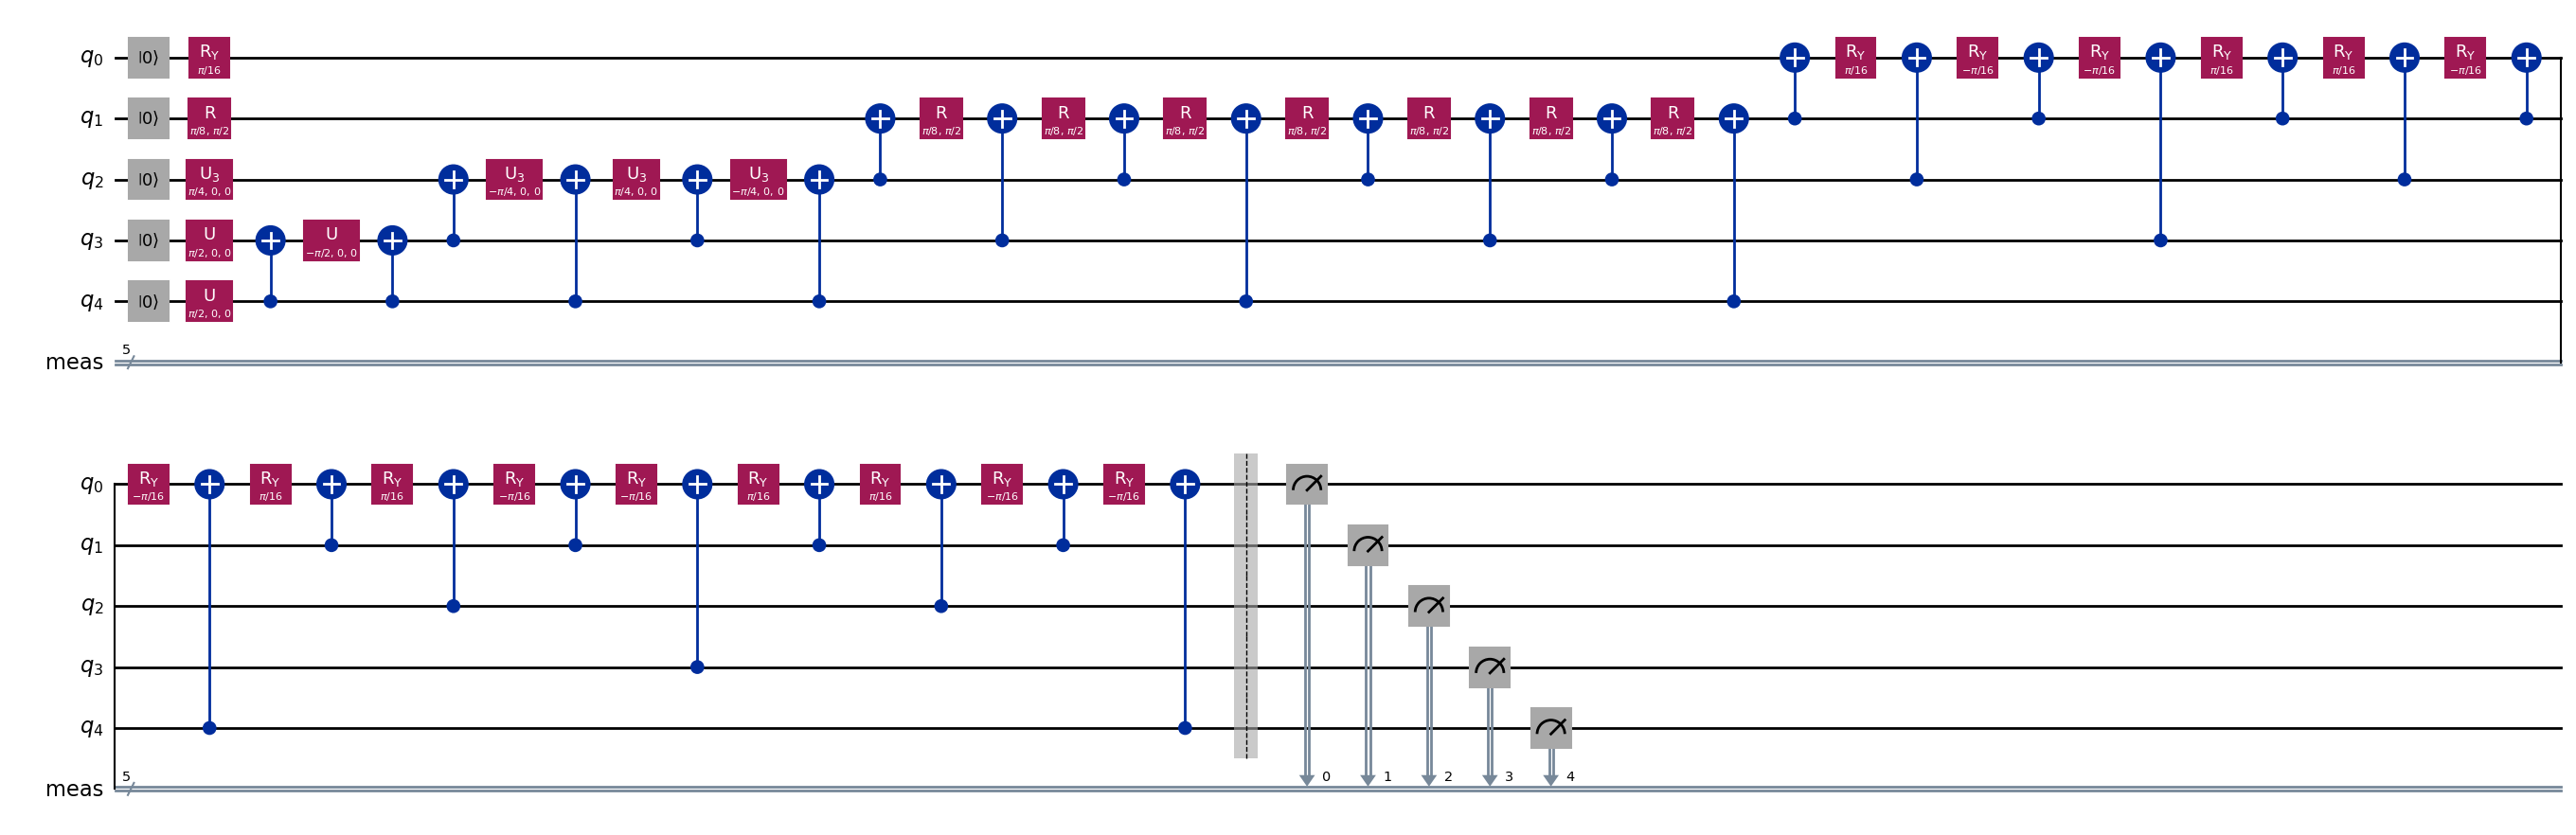

In [4]:
# Draw the decomposition of the amplitude embedding circuit
qc.decompose(reps=8).draw(output="mpl", fold=40)

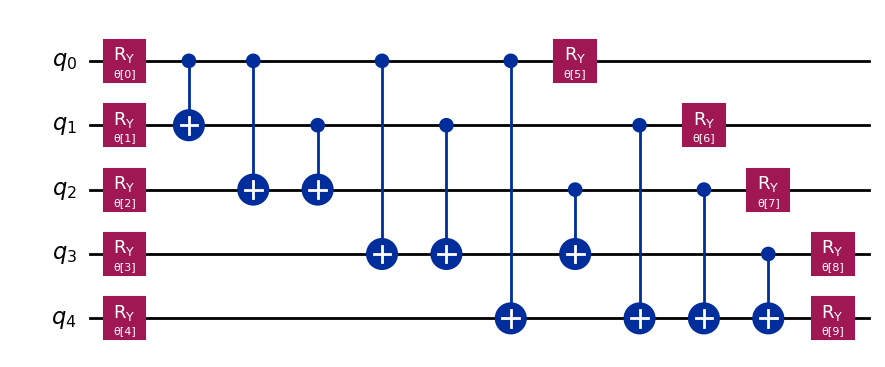

In [5]:
# Map classical inputs to a quantum problem

num_qubits = 5
reps = 1
entanglement = 'full' 
ansatz = RealAmplitudes(num_qubits=num_qubits, entanglement=entanglement,reps=reps)
# Add code here to draw the ansatz circuit
ansatz.decompose().draw('mpl')

In [6]:
# Optimize the problem for quantum execution and execute it using Qiskit primitives

# Define the observable 
obs = SparsePauliOp("ZZZZZ")
# Define the estimator and pass manager
estimator = StatevectorEstimator() #To train we use StatevectorEstimator to get the exact simulation
pm = generate_preset_pass_manager(backend=AerSimulator(), optimization_level=3, seed_transpiler=0) 
# Define the cost function
def cost_func(params, list_coefficients, list_labels, ansatz, obs, estimator, pm, callback_dict):

    """Return cost function for optimization

    Parameters:
        params (ndarray): Array of ansatz parameters
        list_coefficients (list): List of arrays of complex coefficients
        list_labels (list): List of labels
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        obs (SparsePauliOp): Observable
        estimator (EstimatorV2): Statevector estimator primitive instance
        pm (PassManager): Pass manager
        callback_dict (dict): Dictionary to store callback information

    Returns:
        float: Cost function estimate
    """

    cost = 0
    for amplitudes,label in zip(list_coefficients, list_labels):
        qc = QuantumCircuit(num_qubits)
        # Amplitude embedding
        qc.initialize(amplitudes)
        # Compose initial state + ansatz
        classifier = qc.compose(ansatz) 
        # Transpile classifier
        transpiled_classifier = pm.run(classifier)
        # Transpile observable
        transpiled_obs = obs.apply_layout(layout=transpiled_classifier.layout)
        # Run estimator
        pub = (transpiled_classifier, transpiled_obs, params)
        job = estimator.run([pub])
        # Get result
        result = job.result()[0].data.evs
        # Compute cost function (cumulative)
        cost += np.abs(result - label)

    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = params
    callback_dict["cost_history"].append(cost)

    # Print the iterations to screen on a single line
    print(
        "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], cost),
        end="\r",
        flush=True,
    )
    
    return cost

In [7]:
# Training the Variational Quantum Eigensolver

# Intialize the lists to store the results from different runs
cost_history_list = []
res_list = []

# Retrieve the initial parameters
params_0_list = np.load("/kaggle/input/params-0-list/params_0_list.npy")

for it, params_0 in enumerate(params_0_list):

    print('Iteration number: ', it)
    
    # Initialize a callback dictionary
    callback_dict = {
        "prev_vector": None,
        "iters": 0,
        "cost_history": [],
    }

    # Minimize the cost function using scipy
    res = minimize(
        cost_func, 
        params_0, 
        args=(list_coefficients, list_labels, ansatz, obs, estimator, pm, callback_dict), 
        method="cobyla", # Classical optimizer
        options={'maxiter': 200}) # Maximum number of iterations
    
    # Print the results after convergence
    print(res)

    # Save the results from different runs
    res_list.append(res)
    cost_history_list.append(callback_dict["cost_history"])

Iteration number:  0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 4.131828638277623
       x: [ 3.567e+00 -3.317e-01  7.925e-02  3.672e+00  4.967e+00
            1.571e+00 -2.506e-07  5.915e+00  2.542e+00  3.077e+00]
    nfev: 177
   maxcv: 0.0
Iteration number:  1
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 5.000097082711643
       x: [-2.221e-03 -1.630e-03  3.626e-01 -3.832e-01  1.835e+00
            6.886e-01  1.565e+00  1.233e+00  1.117e+00 -1.153e-01]
    nfev: 111
   maxcv: 0.0
Iteration number:  2
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 4.095047001213298
       x: [ 4.018e+00  3.109e+00  3.213e+00  3.394e+00  1.038e+00
            2.281e+00  3.101e+00  3.054e+00  3.213e+00  2.585e+00]
    nfev: 159
   maxcv: 0.0
Iteration number:  3
 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: 4.048073684104578


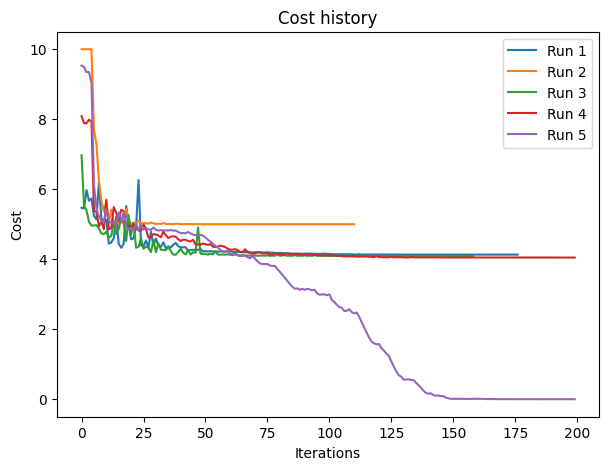

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title('Cost history')
ax.set_ylabel('Cost')
ax.set_xlabel('Iterations')

# Add your code here
for i, cost_history in enumerate(cost_history_list):
    ax.plot(cost_history, label=f'Run {i+1}')
ax.legend()
plt.show()

# Save the optimized parameters if needed
np.save("optimized_params.npy", np.array([res.x for res in res_list]))

Performance for trial 0: 87.08803550538242
Performance for trial 1: 84.37469661652611
Performance for trial 2: 87.20297812120845
Performance for trial 3: 87.34976973717319
Performance for trial 4: 99.99961373897177


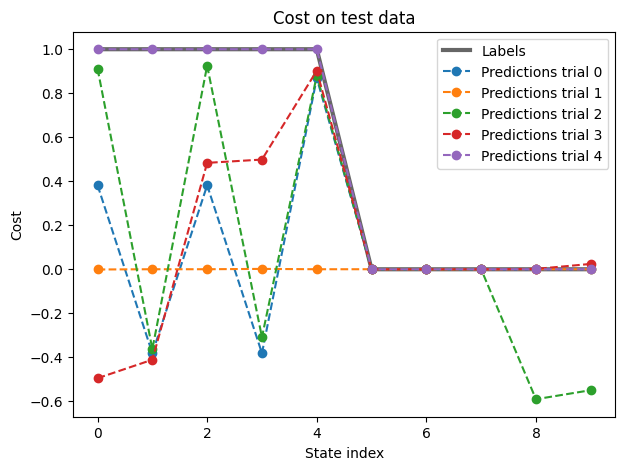

In [9]:
# functions to return performance of classifier
def test_VQC(list_coefficients, list_labels, ansatz, obs, opt_params, estimator, pm):
    results_test = []
    
    for amplitudes, label in zip(list_coefficients, list_labels):
        qc = QuantumCircuit(num_qubits)
        qc.initialize(amplitudes)
        transpiled_classifier = pm.run(qc.compose(ansatz))
        pub = (transpiled_classifier, obs.apply_layout(layout=transpiled_classifier.layout), opt_params)
        job = estimator.run([pub])
        result = job.result()[0].data.evs
        results_test.append(result)
        
    return results_test


def compute_performance(result_list, list_labels):
    sum_diff = 0
    for result, label in zip(result_list, list_labels):
        diff = abs(result - label)
        sum_diff += diff

    normalized_diff = sum_diff / (2 ** 5)
    performance = 100 - 100 * normalized_diff
    return performance

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title('Cost on test data')
ax.set_ylabel('Cost')
ax.set_xlabel('State index')

ax.plot(list_labels, 'k-', linewidth=3, alpha=0.6, label='Labels')

for index in range(len(res_list)):
    opt_params = res_list[index].x
    results_test = test_VQC(list_coefficients, list_labels, ansatz, obs, opt_params, estimator, pm)
    print(f"Performance for trial {index}: {compute_performance(results_test, list_labels)}")
    ax.plot(results_test, 'o--', label='Predictions trial '+str(index))

ax.legend()

Performance for run 4: 99.99961373897175
Performance for run 4: 99.99961373897175
Performance for run 4: 99.99961373897175
Performance for run 4: 99.99961373897175


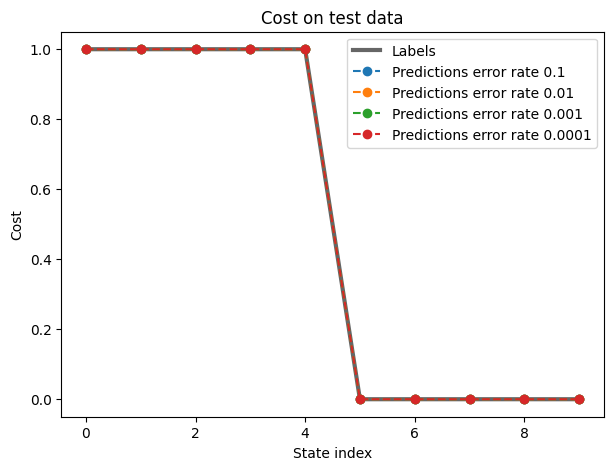

In [10]:
# simulating noise on local device to test if VQC can distinguish dataset
# types: decoherence, measurement, gate, crosstalk errors

fake_backend = GenericBackendV2(
    num_qubits=5,
    basis_gates=["id", "rz", "sx", "x", "cx"]
  )

best_result_index = 4

def update_error_rate(backend, error_rates):

    """Updates the error rates of the backend

    Parameters: 
        backend (BackendV2): Backend to update
        error_rates (dict): Dictionary of error rates

    Returns:    
        None
    """

    default_duration=1e-8
    if "default_duration" in error_rates:
        default_duration = error_rates["default_duration"]

    # Update the 1-qubit gate properties 
    for i in range(backend.num_qubits):
        qarg = (i,)
        if "rz_error" in error_rates:
            backend.target.update_instruction_properties('rz', qarg, InstructionProperties(error=error_rates["rz_error"], duration=default_duration))
        if "x_error" in error_rates:
            backend.target.update_instruction_properties('x', qarg, InstructionProperties(error=error_rates["x_error"], duration=default_duration))
        if "sx_error" in error_rates:
            backend.target.update_instruction_properties('sx', qarg, InstructionProperties(error=error_rates["sx_error"], duration=default_duration)) 
        if "measure_error" in error_rates:
            backend.target.update_instruction_properties('measure', qarg, InstructionProperties(error=error_rates["measure_error"], duration=default_duration))            
    
    # Update the 2-qubit gate properties (CX gate) for all edges in the chosen coupling map
    if "cx_error" in error_rates:    
        for edge in backend.coupling_map:
            backend.target.update_instruction_properties('cx', tuple(edge), InstructionProperties(error=error_rates["cx_error"], duration=default_duration))

error_rates = {
  "default_duration": 1e-8,
  "rz_error": 1e-8,
  "x_error": 1e-8,
  "sx_error": 1e-8,
  "measure_error": 1e-8,
  "cx_error": 1e-8
}

update_error_rate(fake_backend, error_rates)

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title('Cost on test data')
ax.set_ylabel('Cost')
ax.set_xlabel('State index')
ax.plot(list_labels, 'k-', linewidth=3, alpha=0.6, label='Labels')

error_rate_list = [1e-1, 1e-2, 1e-3, 1e-4]

fake_backend = GenericBackendV2(
    num_qubits=5,
    basis_gates=["id", "rz", "sx", "x", "cx"]
  )

# testing the VQC on the fake backend
for error_rate_value in error_rate_list:

    error_rates['rz_error'] = error_rate_value
    error_rates['cx_error'] = error_rate_value

    update_error_rate (fake_backend, error_rates)
    
    estimator = StatevectorEstimator()
    pm = generate_preset_pass_manager(backend=fake_backend,optimization_level=3, seed_transpiler=0)

    opt_params = res_list[best_result_index].x
    results_test = test_VQC(list_coefficients, list_labels, ansatz, obs, opt_params, estimator, pm)

    print(f"Performance for run {index}: {compute_performance(results_test, list_labels)}")
    ax.plot(results_test, 'o--', label='Predictions error rate '+str(error_rate_value))
    
ax.legend()

backend_converter.convert_to_target:INFO:2024-07-12 01:15:29,049: Gate calibration for instruction measure on qubits (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126) is found in the PulseDefaults payload. However, this entry is not defined in the gate mapping of Target. This calibration is ignored.
backend_converter.convert_to_target:INFO:2024-07-12 01:15:29,052: Gate calibration for instruction u1 on qubits (0,) is found in the PulseDefaults payload. However, this entry is not defined in the gate mapping of Target. T

Depth of two-qubit gates:  43


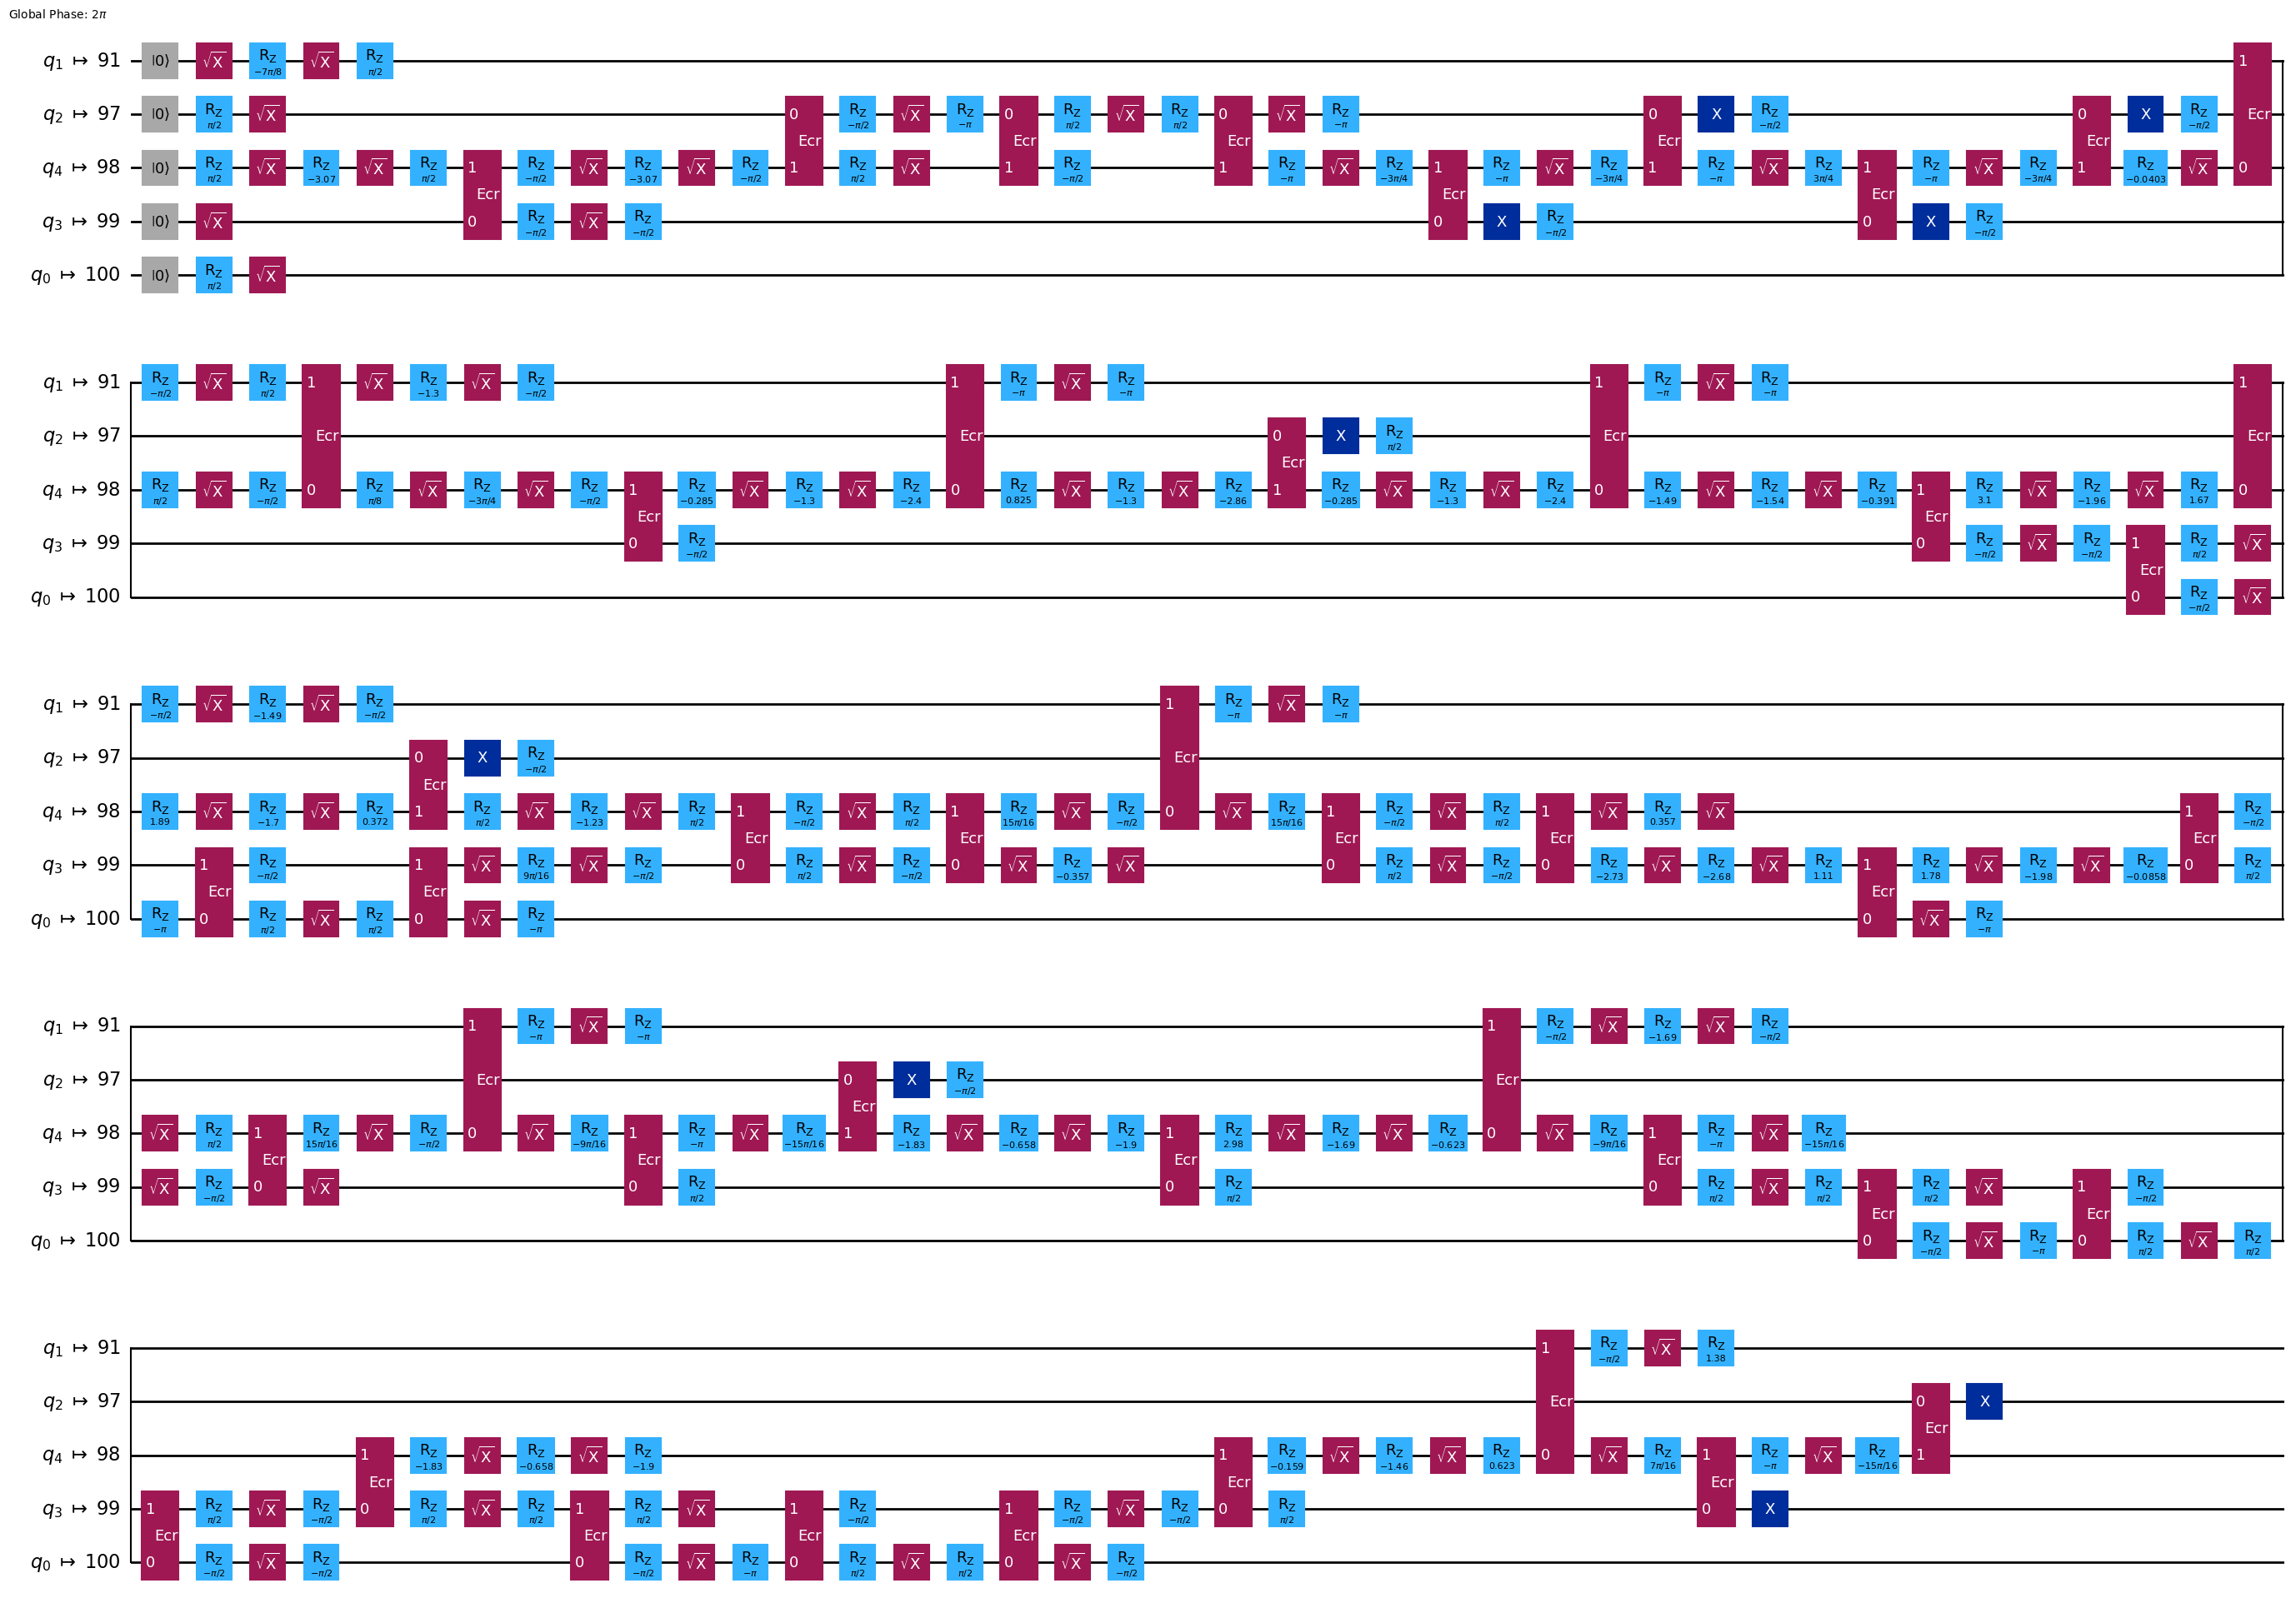

In [11]:
# now using AERSimulator and real quantum backend to test VQC

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
api_key = user_secrets.get_secret("IBM_API_KEY")

# Choose a real backend
service = QiskitRuntimeService(
   channel='ibm_quantum',
   instance='ibm-q/open/main',
   token=api_key
)
backend = service.backend("ibm_osaka")

# Define a fake backend with the same properties as the real backend
fake_backend = AerSimulator.from_backend(backend)

index_bird = 0 #you can check different birds by changing the index
qc = QuantumCircuit(num_qubits)
qc.initialize(list_coefficients[index_bird])
pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)
transpiled_qc = pm.run(qc)

print('Depth of two-qubit gates: ', transpiled_qc.depth(lambda x: len(x.qubits) == 2))
transpiled_qc.draw(output="mpl", idle_wires=False, fold=40)

Depth of two-qubit gates:  52


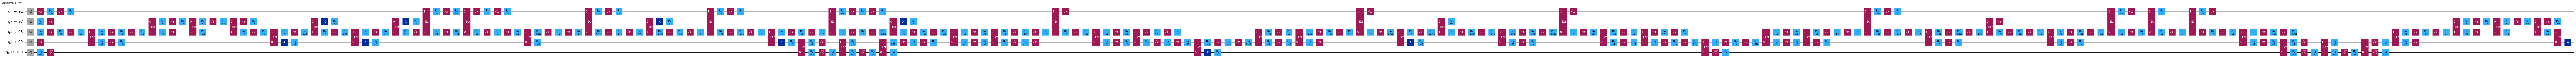

In [12]:
# for ibm quantum birds [0, 1, 2, 3, 4]- generate GHZ state, change index to binary rep
# for non ibm quantum birds [5, 6, 7, 8, 9]- state is the product state corresponding to binary rep

def amplitude_embedding(num_qubits, bird_index):
    """Create amplitude embedding circuit

    Parameters: 
        num_qubits (int): Number of qubits for the ansatz
        bird_index (int): Data index of the bird

    Returns:
        qc (QuantumCircuit): Quantum circuit with amplitude embedding of the bird
    """
    def generate_GHZ(qc):
        qc.h(0)
        for i, j in zip(range(num_qubits-1), range(1,num_qubits)):
            qc.cx(i, j)
    
    qc = QuantumCircuit(num_qubits)    
    qc.initialize(amplitudes, range(num_qubits))
    binary_index = format(bird_index, '05b')

    if (bird_index < 5) :
        generate_GHZ(qc)
    for i, bit in enumerate(reversed(binary_index)):
        if bit == '1':
            qc.x(i) 

    return qc
    
index_bird = 2 

qc = amplitude_embedding(num_qubits, index_bird)
pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)
transpiled_qc = pm.run(qc)

print('Depth of two-qubit gates: ', transpiled_qc.depth(lambda x: len(x.qubits) == 2))
transpiled_qc.draw(output="mpl", fold=False, idle_wires=False)

Depth of two-qubit gates:  18


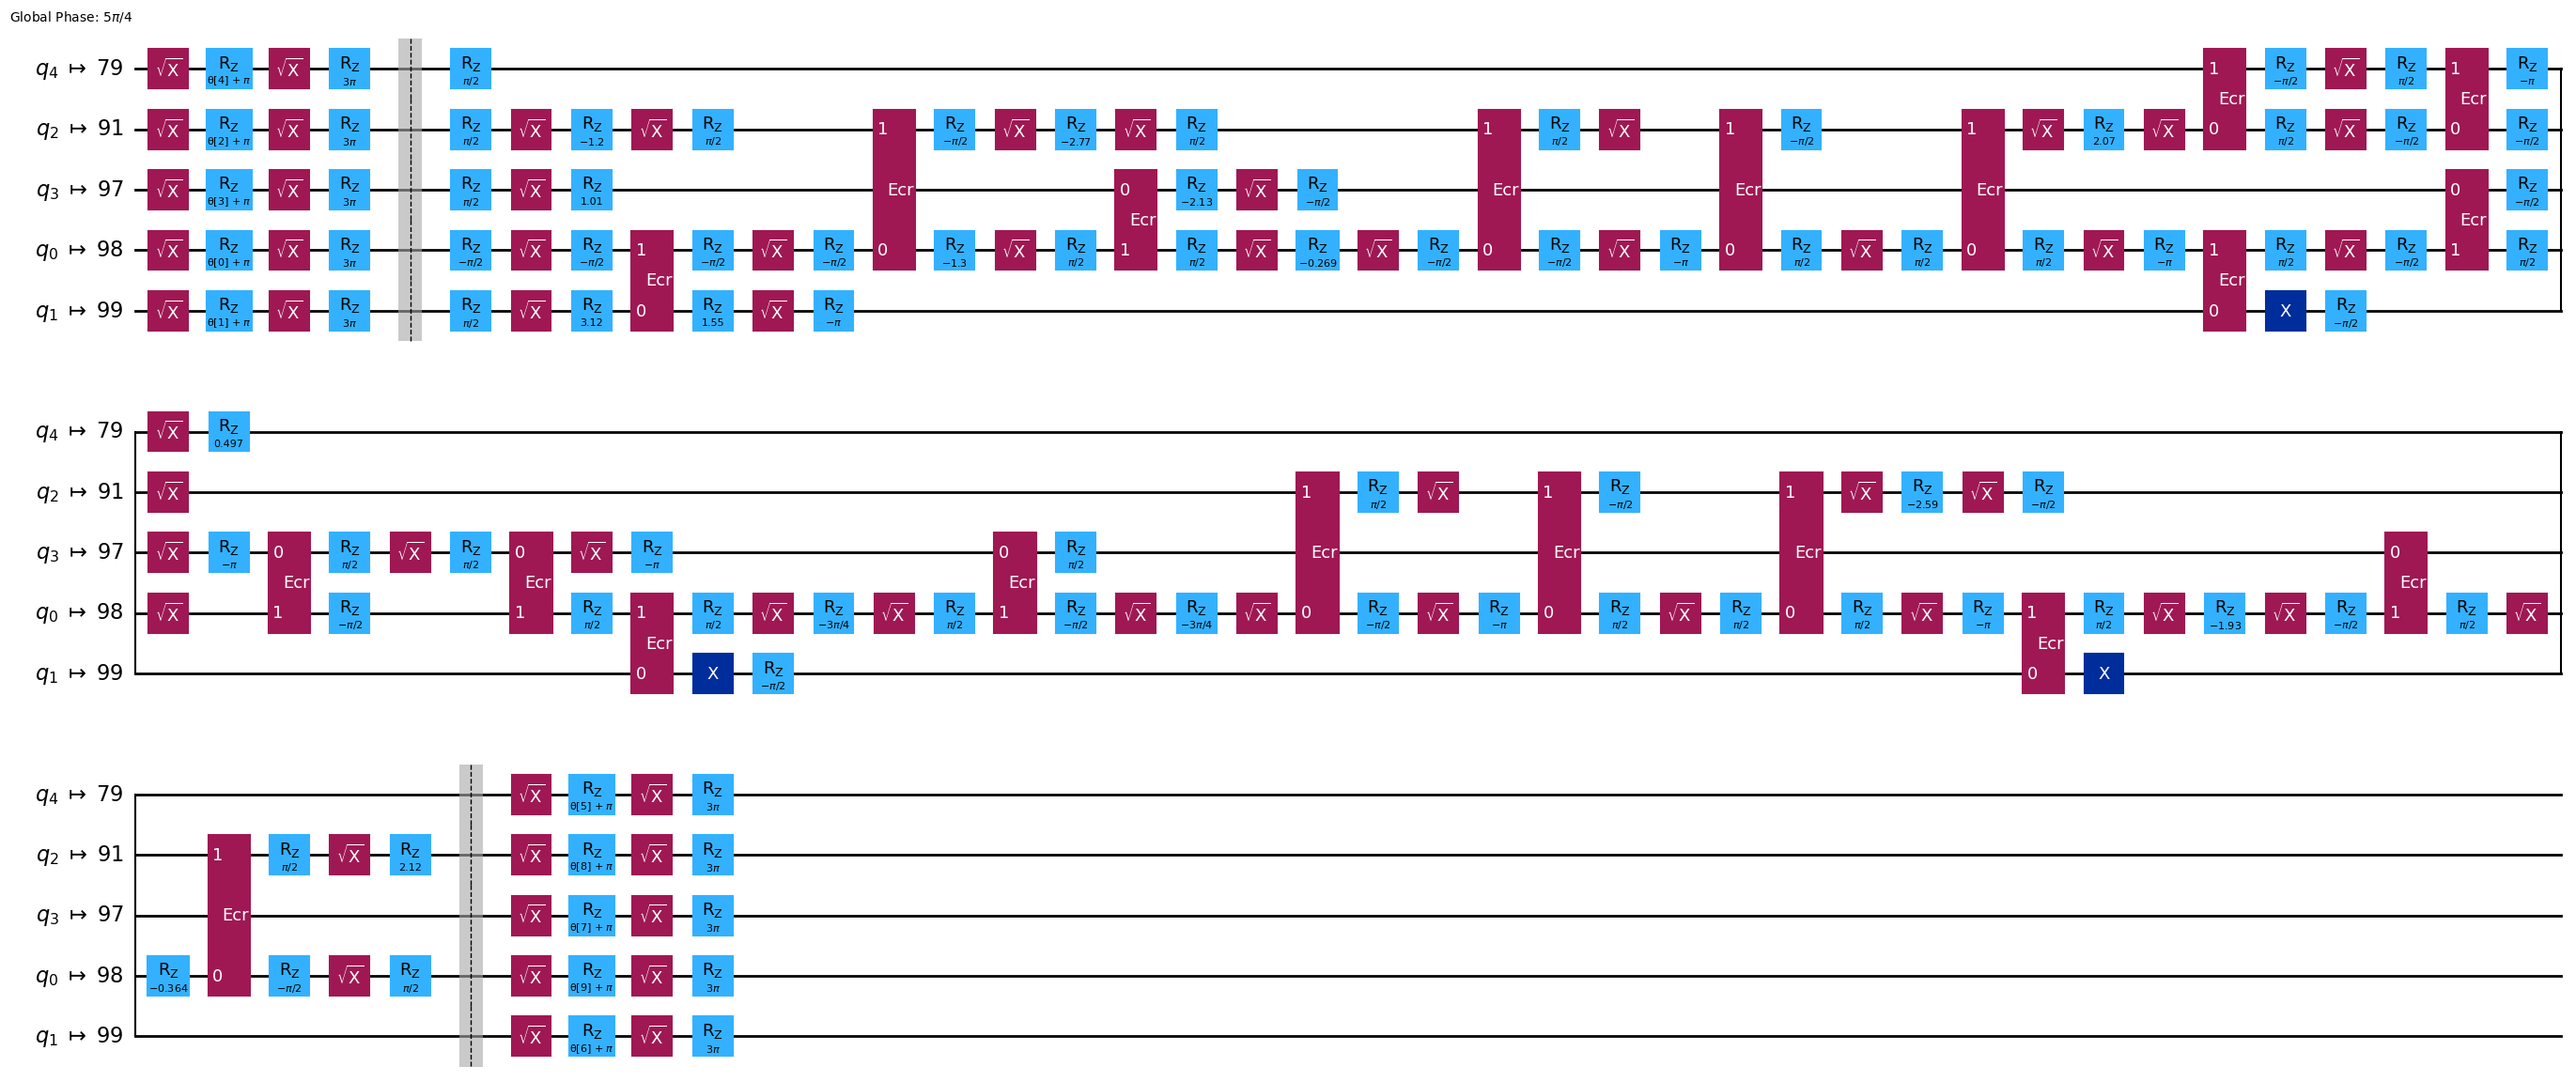

In [13]:
old_ansatz = RealAmplitudes(num_qubits, reps=1, entanglement='full', insert_barriers=True)
pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)
transpiled_ansatz = pm.run(old_ansatz)

print('Depth of two-qubit gates: ', transpiled_ansatz.depth(lambda x: len(x.qubits) == 2))
transpiled_ansatz.draw(output="mpl", idle_wires=False, fold=40)

Depth of two-qubit gates:  2


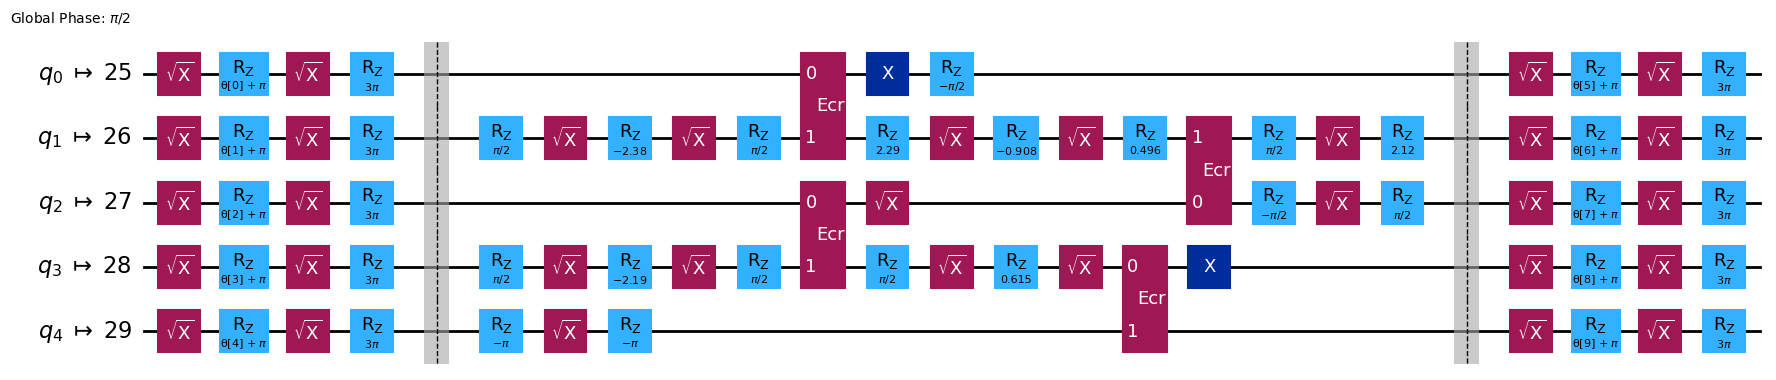

In [14]:
ansatz = RealAmplitudes(num_qubits, reps=1, entanglement='pairwise', insert_barriers=True)
pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)
transpiled_ansatz = pm.run(ansatz)

print('Depth of two-qubit gates: ', transpiled_ansatz.depth(lambda x: len(x.qubits) == 2))
transpiled_ansatz.draw(output="mpl", fold=False, idle_wires=False)

In [15]:
old_mapping = QuantumCircuit(num_qubits)
old_mapping.initialize(list_coefficients[index_bird])
old_classifier = old_mapping.compose(old_ansatz)

new_mapping = amplitude_embedding(num_qubits, index_bird)
new_classifier = new_mapping.compose(ansatz)

pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)
old_transpiled_classifier = pm.run(old_classifier)
new_transpiled_classifier = pm.run(new_classifier)

print('Old depth of two-qubit gates: ', old_transpiled_classifier.depth(lambda x: len(x.qubits) == 2))
print('Current depth of two-qubit gates: ', new_transpiled_classifier.depth(lambda x: len(x.qubits) == 2))

Old depth of two-qubit gates:  66
Current depth of two-qubit gates:  57


base_primitive._run:INFO:2024-07-12 01:15:49,571: Submitting job using options {'options': {'default_shots': 5000}, 'version': 2, 'support_qiskit': True}
base_primitive._run:INFO:2024-07-12 01:15:54,207: Submitting job using options {'options': {'default_shots': 5000}, 'version': 2, 'support_qiskit': True}
base_primitive._run:INFO:2024-07-12 01:15:59,988: Submitting job using options {'options': {'default_shots': 5000}, 'version': 2, 'support_qiskit': True}
base_primitive._run:INFO:2024-07-12 01:16:05,411: Submitting job using options {'options': {'default_shots': 5000}, 'version': 2, 'support_qiskit': True}
base_primitive._run:INFO:2024-07-12 01:16:10,830: Submitting job using options {'options': {'default_shots': 5000}, 'version': 2, 'support_qiskit': True}
base_primitive._run:INFO:2024-07-12 01:16:16,018: Submitting job using options {'options': {'default_shots': 5000}, 'version': 2, 'support_qiskit': True}
base_primitive._run:INFO:2024-07-12 01:16:21,380: Submitting job using optio

Performance: 82.1425


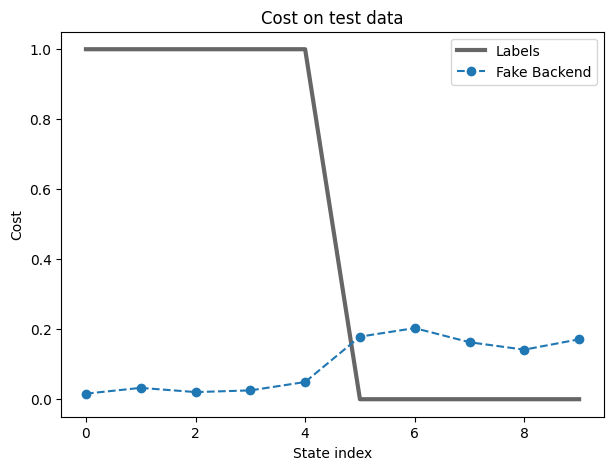

In [16]:
def test_shallow_VQC(list_labels, ansatz, obs, opt_params, estimator, pm):
    """Return the performance of the classifier

    Parameters:
        list_labels (list): List of labels
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        obs (SparsePauliOp): Observable
        opt_params (ndarray): Array of optimized parameters
        estimator (EstimatorV2): Statevector estimator
        pm (PassManager): Pass manager for transpilation 
        
    Returns:
        results_test (list): List of test results
    """

    results_test = []

    for idx in range(len(list_labels)):
        num_qubits = ansatz.num_qubits
        bird_index = idx

        qc = amplitude_embedding(num_qubits=num_qubits, bird_index=bird_index)
        transpiled_classifier = pm.run(qc.compose(ansatz))
        pub = (transpiled_classifier, obs.apply_layout(layout=transpiled_classifier.layout), opt_params)
        job = estimator.run([pub])
        result = abs(job.result()[0].data.evs)
        results_test.append(result)
        
    return results_test

estimator = Estimator(mode=fake_backend)
estimator.options.default_shots = 5000
pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)

opt_params = np.load('/kaggle/input/opt-param-shallow-vqc/opt_params_shallow_VQC.npy')
results_test = test_shallow_VQC(list_labels, ansatz, obs, opt_params, estimator, pm)

print(f"Performance: {compute_performance(results_test, list_labels)}")

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title('Cost on test data')
ax.set_ylabel('Cost')
ax.set_xlabel('State index')
ax.plot(list_labels, 'k-', linewidth=3, alpha=0.6, label='Labels')
ax.plot(results_test, 'o--', label='Fake Backend')
ax.legend()

In [17]:
# testing shallow VQC on IBM Quantum backend

service = QiskitRuntimeService(
   channel='ibm_quantum',
   instance='ibm-q/open/main',
   token=api_key
)
backend = service.backend("ibm_osaka")

def test_shallow_VQC_QPU(list_labels, anstaz, obs, opt_params, options, backend):
    
    """Return the performance of the classifier

    Parameters:
        list_labels (list): List of labels 
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        obs (SparsePauliOp): Observable
        opt_params (ndarray): Array of optimized parameters
        options (EstimatorOptions): Estimator options
        backend (service.backend): Backend to run the job 
        
    Returns:
        job_id (str): Job ID
    """

    estimator = Estimator(mode=backend, options=options)
    pm = generate_preset_pass_manager(optimization_level=3, backend=backend)

    pubs = []
    for bird, label in enumerate(list_labels):
        transpiled_classifier = pm.run(ansatz)
        transpiled_obs = pm.run(obs)
        
        pub = (transpiled_classifier, transpiled_obs, opt_params)
        pubs.append(pub)
        
    job = estimator.run(pubs)
    job_id = job.job_id()
    print(f"Job ID: {job_id}")
    print(f"Status: {job.status()}")
                                           
    return job_id

## No DD, no TREX (no ZNE)
options_0 = EstimatorOptions()
options_0.optimization_level = 0
options_0.resilience_level = 0
options_0.default_shots = 5000
options_0.dynamical_decoupling.enable = False
options_0.dynamical_decoupling.sequence_type = 'XpXm'


## DD + TREX (no ZNE)
options_1 = EstimatorOptions()
options_1.optimization_level = 0
options_1.resilience_level = 1
options_1.default_shots = 5000
options_1.dynamical_decoupling.enable = True
options_1.dynamical_decoupling.sequence_type = 'XpXm'
options_1.twirling.enable_measure = True